In [52]:
#Importing all packages
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats
from matplotlib.font_manager import FontProperties
import geopy
from geopy.geocoders import Nominatim

In [53]:
def getLineSlope (p_li_y_axis_vals=[], p_li_x_axis_vals=[]): 
    p_li_y_axis_vals = [val for val in p_li_y_axis_vals if str(val) != 'nan']
    if not p_li_x_axis_vals or (len(p_li_y_axis_vals)!=len(p_li_x_axis_vals)):
        p_li_x_axis_vals = [i for i in range(len(p_li_y_axis_vals))]
    slope, intercept, r_value, p_value, std_err = stats.linregress(p_li_x_axis_vals, p_li_y_axis_vals)
    return round(slope,6)

In [54]:
#Loading input files

#Zillow data
cost_data = pd.read_csv("/Users/amritajose/Downloads/Zillow_Data.csv",low_memory = False)
#Airbnb data
revenue_data = pd.read_csv('/Users/amritajose/Downloads/Airbnb_Data.csv')
#Exploring both datasets 
print("*************Zillow***************")
print("Zillow data dimensions - ",cost_data.shape)
print(cost_data.head(2))
print(cost_data.columns.values) 
print("\n\n*************Airbnb***************")
print("Airbnb data dimensions - ",revenue_data.shape)
print(revenue_data.head(2))
print(revenue_data.columns.values)

*************Zillow***************
Zillow data dimensions -  (8946, 262)
   RegionID  RegionName      City State     Metro CountyName  SizeRank  \
0     61639       10025  New York    NY  New York   New York         1   
1     84654       60657   Chicago    IL   Chicago       Cook         2   

    1996-04   1996-05   1996-06  ...  2016-09  2016-10  2016-11    2016-12  \
0       NaN       NaN       NaN  ...  1374400  1364100  1366300  1354800.0   
1  167700.0  166400.0  166700.0  ...   368600   370200   372300   375300.0   

   2017-01  2017-02  2017-03  2017-04  2017-05  2017-06  
0  1327500  1317300  1333700  1352100  1390000  1431000  
1   378700   381400   381800   382100   383300   385100  

[2 rows x 262 columns]
['RegionID' 'RegionName' 'City' 'State' 'Metro' 'CountyName' 'SizeRank'
 '1996-04' '1996-05' '1996-06' '1996-07' '1996-08' '1996-09' '1996-10'
 '1996-11' '1996-12' '1997-01' '1997-02' '1997-03' '1997-04' '1997-05'
 '1997-06' '1997-07' '1997-08' '1997-09' '1997-10' '1997-

In [55]:
#Function to check duplicate values in the Zillow and Airbnb dataset and verify the data types for computation 
#of cost and revenue
def data_checker(dataset):
     if(dataset.duplicated().any == True):
        dataset.drop_duplicates(inplace=True)
     return dataset.dtypes

In [56]:
#Quality Check - Data Cleaning/Preprocessing- Zillow Dataset

def zillow_data_qualitycheck(cost_data,city):
    #Filtering the data to only consider 'New York' out of all listed cities
    
    #Data subsetting
    cost_Nydata = cost_data[cost_data.City == city]
    
    #Handling missing values
    #Identify columns with missing values
    missingValueColumns = cost_Nydata.columns[cost_Nydata.isnull().any()].tolist()
    #Fetching the historical median price for each year-month and plotting missing value counts for each (up till 2007-05)
    #as there are no missing values in the columns after.
    cost_Nydata_missingcounts = cost_Nydata.iloc[:, 7:141].isnull().sum()
    list_of_years = list(range(1996, 2018))
    average_of_cost_by_years = [cost_Nydata_missingcounts[cost_Nydata_missingcounts.index.str.startswith(str(year))].mean() for year in list_of_years]
    average_of_cost_by_years = [0 if math.isnan(x) else x for x in average_of_cost_by_years]
    
    # Defines the chart font style
    font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 8}

    # includes the chart font style
    plt.rc('font', **font)
    figure(num=None, figsize=(10, 3))
    plt.bar(list_of_years, average_of_cost_by_years, width=0.5, color = 'c', label='legend title')
    plt.ylabel('Average number of missing values',size=12)
    plt.xlabel('Year',size=12)
    plt.title("Average number of missing values per year",size=15)
    plt.show()
    #From the plot, it can be observed that the percentage/count of missing values is decreasing with years. 
    #Count of missing values is almost exponentially decreasing from year 2003 until 2007, after which it is 0
    
    #Identifying columns with more than 20% missing values
    missinggt20 = round(cost_Nydata.isnull().mean()*100,2)>20.00
    print(missinggt20[missinggt20].index.values)
    #Though fields from 2004 - 09 TO 2007 - 05 have less than 20% missing values, they still have missing data 
    #due to which they will be omitted from computation of price. 
    #Also 10 years of data(from 2007-06 to 2017-06) should be sufficient to capture trend and calculate price.
    
    #Verifying for duplicate occurences and dropping them in case.
    #Also verifying the types of all data fields to handle any conversions
    print(data_checker(cost_Nydata))
    
    print('\nPlotting the yearly median cost per zip code...')
    li=[]
    for year in list_of_years:
       li.append(cost_Nydata.filter(regex=str(year)).median(axis=1, skipna=True))

    result = pd.concat(li, axis=1, sort=False)
    list_of_years_named = [str(x) + '_median' for x in list_of_years]
    result = result.rename(columns=dict(zip(result.columns.tolist(), list_of_years_named)))
    result = pd.concat([cost_Nydata, result],  axis=1, sort=False)
    result['RegionName'] = result['RegionName'].astype(str)
    plot_data = result.groupby('RegionName').agg({str(name):'median' for name in list_of_years_named}).reset_index()
    fontP = FontProperties()
    fontP.set_size('xx-small')
    list_of_final_years = list(range(2007, 2018))
    plot_data = plot_data.iloc[:, [0] + list(range(12, 12+len(list_of_final_years)))]

    for ind, row in plot_data.iterrows():
        plt.plot(list_of_final_years, plot_data.iloc[ind, 1:], label = plot_data.iloc[ind]['RegionName'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
    plt.show()
    
    #It can be observed from the plot that no outliers or significant skewness can be observed from the plot for years
    #2007-2017. 

    #In order to compute a single field that gives a price estimate considering all 10 years,
    #I am using Time series analysis to calculate the moving average of prices over the years. 
    #While mean and median of last 10 years are also viable options, moving average will consider the 
    #trend over time and smooth the pricing. 
    #Also, I am using exponential moving average (instead of simple moving average) as it gives more weight 
    #to the recent year-month prices and captures the trend better while being more up to date.
    cost_Nydata_prices=cost_Nydata.iloc[:, 141:262]
    ema_list = []
    for i in cost_Nydata_prices.iterrows():
        exp_moving_average = round(i[1].ewm(alpha=0.1, adjust=False).mean(),2)
        ema_list.append(exp_moving_average[exp_moving_average.index[-1]])
    #Returning preprocessed cost data
    cost_Nydata['Cost_Estimate'] = ema_list
    print(cost_Nydata.head(3))
    #Returning only relevant columns in the dataframe including RegionName, City, CountyName, SizeRank and Cost_Estimate
    cost_data_subset = cost_Nydata[['RegionName','City','CountyName','SizeRank','Cost_Estimate']]
    return cost_data_subset
                                   

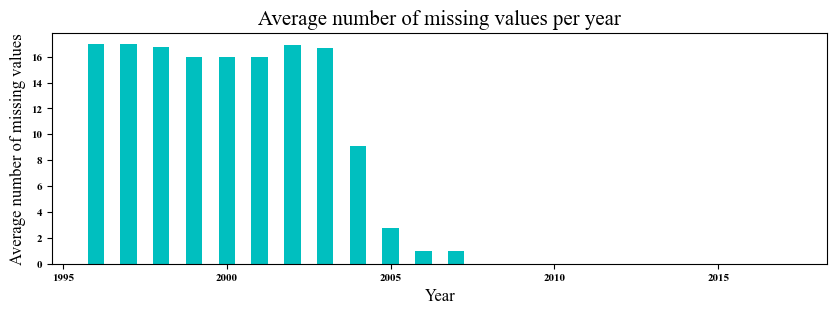

['1996-04' '1996-05' '1996-06' '1996-07' '1996-08' '1996-09' '1996-10'
 '1996-11' '1996-12' '1997-01' '1997-02' '1997-03' '1997-04' '1997-05'
 '1997-06' '1997-07' '1997-08' '1997-09' '1997-10' '1997-11' '1997-12'
 '1998-01' '1998-02' '1998-03' '1998-04' '1998-05' '1998-06' '1998-07'
 '1998-08' '1998-09' '1998-10' '1998-11' '1998-12' '1999-01' '1999-02'
 '1999-03' '1999-04' '1999-05' '1999-06' '1999-07' '1999-08' '1999-09'
 '1999-10' '1999-11' '1999-12' '2000-01' '2000-02' '2000-03' '2000-04'
 '2000-05' '2000-06' '2000-07' '2000-08' '2000-09' '2000-10' '2000-11'
 '2000-12' '2001-01' '2001-02' '2001-03' '2001-04' '2001-05' '2001-06'
 '2001-07' '2001-08' '2001-09' '2001-10' '2001-11' '2001-12' '2002-01'
 '2002-02' '2002-03' '2002-04' '2002-05' '2002-06' '2002-07' '2002-08'
 '2002-09' '2002-10' '2002-11' '2002-12' '2003-01' '2003-02' '2003-03'
 '2003-04' '2003-05' '2003-06' '2003-07' '2003-08' '2003-09' '2003-10'
 '2003-11' '2003-12' '2004-01' '2004-02' '2004-03' '2004-04' '2004-05'
 '2004

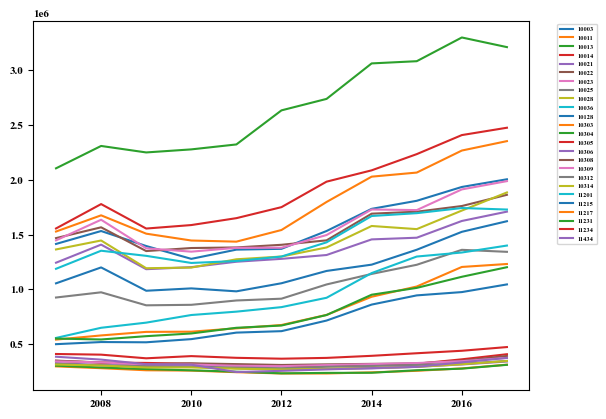

    RegionID  RegionName      City State     Metro CountyName  SizeRank  \
0      61639       10025  New York    NY  New York   New York         1   
2      61637       10023  New York    NY  New York   New York         3   
13     61703       10128  New York    NY  New York   New York        14   

    1996-04  1996-05  1996-06  ...  2016-10  2016-11    2016-12  2017-01  \
0       NaN      NaN      NaN  ...  1364100  1366300  1354800.0  1327500   
2       NaN      NaN      NaN  ...  1980700  1960900  1951300.0  1937800   
13      NaN      NaN      NaN  ...  1523700  1527200  1541600.0  1557800   

    2017-02  2017-03  2017-04  2017-05  2017-06  Cost_Estimate  
0   1317300  1333700  1352100  1390000  1431000     1342325.27  
2   1929800  1955000  2022400  2095000  2142300     1949464.71  
13  1582900  1598900  1646100  1720500  1787100     1564077.19  

[3 rows x 263 columns]


In [57]:
#Calling data preprocessing function for zillow dataset, passing 'New York' as city 
cost_df = zillow_data_qualitycheck(cost_data,'New York')

In [58]:
#Quality Check - Data Cleaning/Preprocessing- Airbnb Dataset

def airbnb_data_qualitycheck(revenue_data,bedroomcount):
    #Checking columns and their indices for faster retrieval
    #for col in revenue_data.columns: 
        #print(col, "-" ,revenue_data.columns.get_loc(col))
    #Data Subsetting
    #Filtering important columns/fields for analysis
    revenuedata = revenue_data.iloc[:,[0,19,40,41,42,43,45,48,49,51,52,53,55,58,59,60,61,62,77,78,79,80,82,86]]
    #Filtering data to obtain properties with 2 bedrooms
    revenue_data_subset = revenuedata[revenuedata.bedrooms == bedroomcount]
    
    #Handling missing values
    #Identify columns with missing values and respective percentage of missing values. 
    #Only columns with less than 20% missing values will be considered and the rest will be dropped or imputed.
    print(round(revenue_data_subset.isnull().mean()*100,2))
    #It can be observed that square_feet, weekly_price and monthly_price have the highest missing values. As 
    #the missing percentages are significantly high and these are not significant variables for 
    #computing revenue, hence they are dropped and not imputed.
    revenue_data_subset.drop(columns=['square_feet', 'weekly_price','monthly_price'],axis=1,inplace=True)
    #Imputing review_scores_rating and replacing null values with 0
    revenue_data_subset.fillna({'review_scores_rating':0}, inplace=True)
    
    #0.77% missing values for zipcode. Zipcode is detrimental for cost-revenue analysis, hence cannot be dropped.
    #Using geopy library to obtain zipcode for missing values by feeding corresponding latitudes and longitudes
    geolocator = geopy.Nominatim(user_agent='zillow-zipcode')
    for i,y in revenue_data_subset.iterrows():
        if(math.isnan(float(y['zipcode']))):
            location = geolocator.reverse((y['latitude'], y['longitude']))
            revenue_data_subset.replace(to_replace = y['zipcode'], value=location.raw['address']['postcode'],inplace=True)
    
    #Updating null values in city with the first value of column 'smart_location' as it presumably 
    #corresponds to the city name based on data
    revenue_data_subset['city_replace']=revenue_data_subset['smart_location'].str.split(',', expand = True)[0]
    revenue_data_subset.city.fillna(revenue_data_subset.city_replace, inplace=True)
    #Updating null values in state as NY
    revenue_data_subset.fillna({'state':"NY"}, inplace=True)
    #Since all missing values have been imputed, verifying whether there are any more missing values
    print("Are there any more missing values? - ",revenue_data_subset.isnull().values.any())
    
    #Handling any duplicate rows in the dataset and verifying the types of all data fields to handle any conversions
    print(data_checker(revenue_data_subset))
    #Zipcode is object type. Converting into numeric
    revenue_data_subset['zipcode'] = pd.to_numeric(revenue_data_subset['zipcode'] )
    
    #Returning the cleaned revenue data
    return revenue_data_subset

In [59]:
#Calling data preprocessing function for airbnb dataset, passing the bedroom count as 2
revenue_df = airbnb_data_qualitycheck(revenue_data, 2)

id                               0.00
host_id                          0.00
neighbourhood_group_cleansed     0.00
city                             0.14
state                            0.02
zipcode                          0.77
smart_location                   0.00
latitude                         0.00
longitude                        0.00
property_type                    0.00
room_type                        0.00
accommodates                     0.00
bedrooms                         0.00
amenities                        0.00
square_feet                     98.45
price                            0.00
weekly_price                    87.84
monthly_price                   89.29
availability_30                  0.00
availability_60                  0.00
availability_90                  0.00
availability_365                 0.00
number_of_reviews                0.00
review_scores_rating            21.29
dtype: float64
Are there any more missing values? -  False
id                           

In [60]:
#Merging the cost and revenue datasets on zipcode
cost_revenue_mergedf = pd.merge(cost_df,revenue_df,left_on='RegionName',right_on='zipcode',how='inner')
#Analysing the merged data
print("Data dimensions",cost_revenue_mergedf.shape)
print("Unique zipcodes",cost_revenue_mergedf.zipcode.unique())
print(cost_revenue_mergedf.describe())
print("Listings in each zipcode\n", cost_revenue_mergedf['zipcode'].value_counts())

#Initial Analysis
#1) There are 24 zipcodes in New York for which profit must be estimated
#2) There are 1565 2 bedroom listings across the 24 zipcodes for which revenue must be computed to determine profit estimates. 
#3) The minimum or lowest cost of properties is $292907.42 and the highest is $3232174.56
#4) The cheapest property in Airbnb is charged $50 per night for stay and the most expensive is charged $4000 per night for stay.
#5) Zipcode 11215 has the highest number of listings(189 listings) whereas zipcode 10309 has only one listing.


Data dimensions (1565, 27)
Unique zipcodes [10025. 10023. 10128. 10011. 10003. 11201. 11234. 10314. 11215. 10028.
 10021. 10014. 10036. 11434. 10306. 10022. 11217. 10013. 11231. 10304.
 10305. 10309. 10308. 10303.]
         RegionName     SizeRank  Cost_Estimate            id       host_id  \
count   1565.000000  1565.000000   1.565000e+03  1.565000e+03  1.565000e+03   
mean   10425.564856   534.359744   1.678377e+06  1.783744e+07  6.271547e+07   
std      561.629414   718.210349   6.270806e+05  1.146884e+07  7.882948e+07   
min    10003.000000     1.000000   2.929074e+05  1.645800e+04  1.148100e+04   
25%    10014.000000    21.000000   1.198038e+06  7.664343e+06  5.162192e+06   
50%    10028.000000    71.000000   1.727500e+06  1.758601e+07  2.377272e+07   
75%    11215.000000   894.000000   1.959752e+06  2.850139e+07  1.043644e+08   
max    11434.000000  4647.000000   3.232175e+06  3.647731e+07  2.730575e+08   

            zipcode     latitude    longitude  accommodates  bedrooms  \


In [61]:
#Calculating revenue 
#Revenue generated by a listing is dependent on two major factors - occupancy rate(which will be assumed as 75%) 
#and the price per night. Since the property is rented out by the real estate company, it can be assumed that the 
#property will be available for all 365 days in an year. Otherwise revenue must be computed as :-
#(Revenue = price per night * occupancy_rate * available_365)

#Calculating revenue per year for the real estate company for each listing
#Revenue per year = Price per night * Occupancy Rate (0.75) * 365

cost_revenue_mergedf['yearly_revenue'] = cost_revenue_mergedf['price'] * 0.75 * 365

#Aggregating data to calculate revenue per year for each zipcode
cost_revenue_aggregatedf = cost_revenue_mergedf.groupby(['RegionName','neighbourhood_group_cleansed','Cost_Estimate'],as_index=False)['yearly_revenue'].mean()
cost_revenue_aggregatedf = pd.DataFrame(cost_revenue_aggregatedf)
print(cost_revenue_aggregatedf.head(3))

#Analysis
#The aggregated data reveals a discrepancy. Zipcode 100013 is assosciated with two areas - Brooklyn and Manhattan
#indicating that the listing details might be incorrectly populated in the Airbnb dataset.

   RegionName neighbourhood_group_cleansed  Cost_Estimate  yearly_revenue
0       10003                    Manhattan     1959751.60    87247.748162
1       10011                    Manhattan     2300227.37   100938.856132
2       10013                     Brooklyn     3232174.56    27375.000000


In [62]:
#Calculating Break Even Time
#Break even time is the time required for the yearly revenue to equal its cost. The break even time (computed in years)
#will give the number of years it will take for the real estate company to offset the cost.
#Zipcodes with smaller break even time will indicate earlier and faster profits.

cost_revenue_aggregatedf['Break_Even_Time'] = cost_revenue_aggregatedf['Cost_Estimate']/cost_revenue_aggregatedf['yearly_revenue']
cost_revenue_aggregatedf['Year_10'] = - cost_revenue_aggregatedf['Cost_Estimate'] + cost_revenue_aggregatedf['yearly_revenue']*10
cost_revenue_aggregatedf['ROI_10'] = (cost_revenue_aggregatedf['Year_10']/cost_revenue_aggregatedf['Cost_Estimate'])*100
cost_revenue_aggregatedf['Year_15'] = - cost_revenue_aggregatedf['Cost_Estimate'] + cost_revenue_aggregatedf['yearly_revenue']*15
cost_revenue_aggregatedf['ROI_15'] = (cost_revenue_aggregatedf['Year_15']/cost_revenue_aggregatedf['Cost_Estimate'])*100
cost_revenue_aggregatedf['Year_20'] = - cost_revenue_aggregatedf['Cost_Estimate'] + cost_revenue_aggregatedf['yearly_revenue']*20
cost_revenue_aggregatedf['ROI_20'] = (cost_revenue_aggregatedf['Year_20']/cost_revenue_aggregatedf['Cost_Estimate'])*100
cost_revenue_aggregatedf['Year_25'] = - cost_revenue_aggregatedf['Cost_Estimate'] + cost_revenue_aggregatedf['yearly_revenue']*25
cost_revenue_aggregatedf['ROI_25'] = (cost_revenue_aggregatedf['Year_25']/cost_revenue_aggregatedf['Cost_Estimate'])*100
cost_revenue_aggregatedf['Year_30'] = - cost_revenue_aggregatedf['Cost_Estimate'] + cost_revenue_aggregatedf['yearly_revenue']*30
cost_revenue_aggregatedf['ROI_30'] = (cost_revenue_aggregatedf['Year_30']/cost_revenue_aggregatedf['Cost_Estimate'])*100

#Analysis
#It could be seen from the data that 10013 occurs twice in the visualization. This is due to the occurence of 
#two locations - Brooklyn and Manhattan for the same zipcode which are considered as two seperate records in the 
#aggregated dataframe. Since 10013 is Manhattan Zipcode, dropping the row for Brooklyn.
cost_revenue_aggregatedf.drop(cost_revenue_aggregatedf.index[2],inplace=True)
cost_revenue_aggregatedf.reset_index(drop=True, inplace=True)
print(cost_revenue_aggregatedf.head(3))

   RegionName neighbourhood_group_cleansed  Cost_Estimate  yearly_revenue  \
0       10003                    Manhattan     1959751.60    87247.748162   
1       10011                    Manhattan     2300227.37   100938.856132   
2       10013                    Manhattan     3232174.56   109694.783654   

   Break_Even_Time       Year_10     ROI_10       Year_15     ROI_15  \
0        22.461916 -1.087274e+06 -55.480201 -6.510354e+05 -33.220301   
1        22.788324 -1.290839e+06 -56.117879 -7.861445e+05 -34.176818   
2        29.465162 -2.135227e+06 -66.061615 -1.586753e+06 -49.092423   

        Year_20     ROI_20        Year_25     ROI_25        Year_30     ROI_30  
0 -2.147966e+05 -10.960401  221442.104044  11.299499  657680.844853  33.559398  
1 -2.814502e+05 -12.235758  223244.033302   9.705303  727938.313962  31.646363  
2 -1.038279e+06 -32.123231 -489804.968654 -15.154038   58668.949615   1.815154  


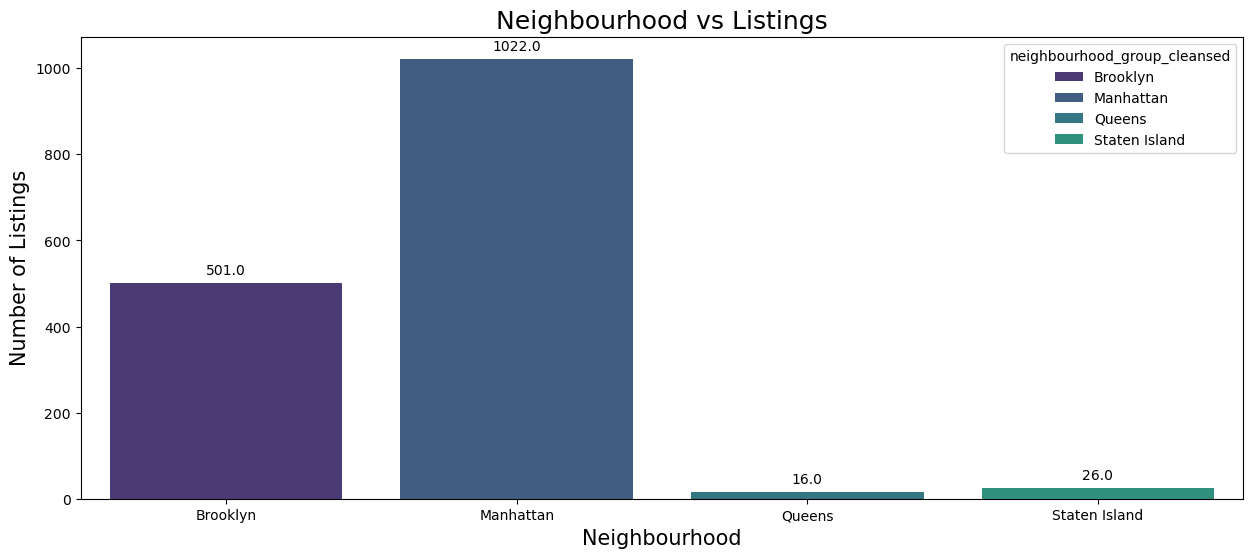

In [63]:
#Visualizing data - Results and Data Exploration for Insights

#Plotting Neighbourhood vs Listings
plt.style.use("default")
plt.figure(figsize=(15,6))
sns.set_palette("viridis")
df = cost_revenue_mergedf.groupby(['neighbourhood_group_cleansed'],as_index=False)['id'].count()
g  = sns.barplot(x = 'neighbourhood_group_cleansed',y = 'id',hue='neighbourhood_group_cleansed',data = df,dodge = False)
for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Neighbourhood", size=15)
plt.ylabel("Number of Listings", size=15)
plt.title("Neighbourhood vs Listings", size=18)
plt.show()

#Analysis
#It could be observed from the plot that Manhattan has the highest number of AirBnB listings. 
#High inventory possibly indicates higher demand. Queens has the lowest inventory in New York City in AirBnB.

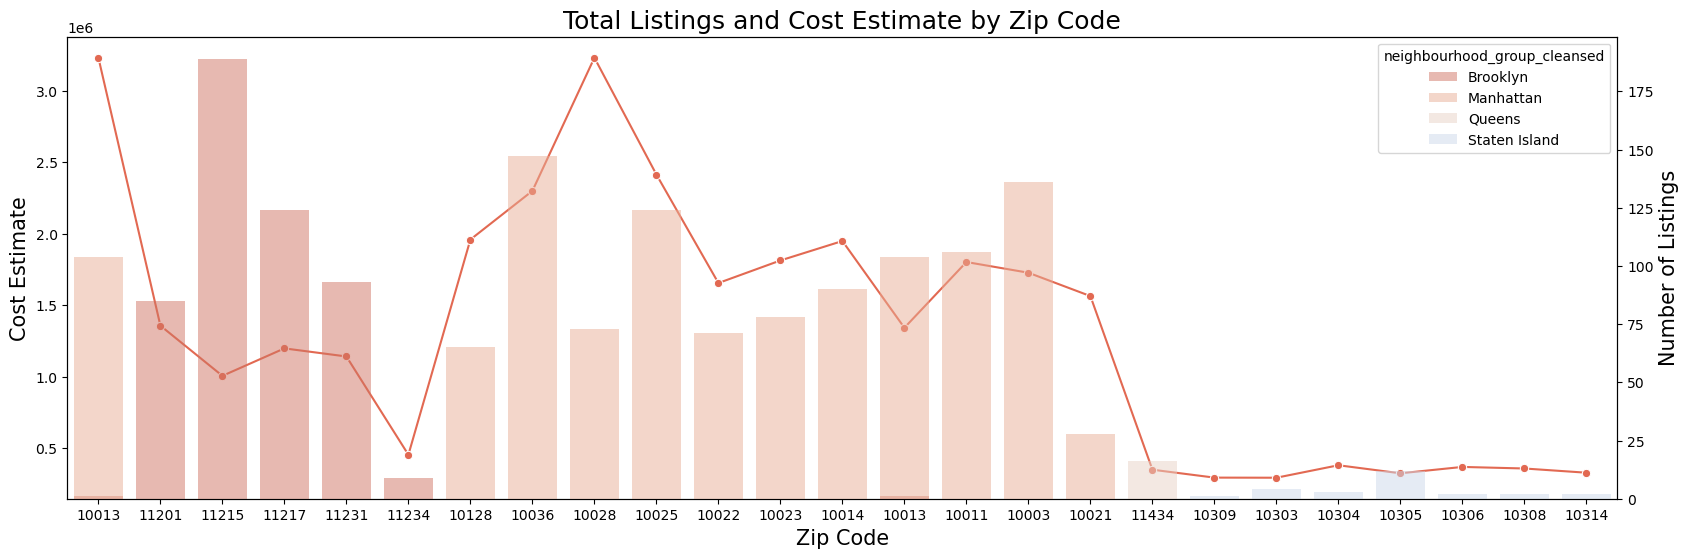

In [64]:
#Plotting Total Listings and Cost Estimate by Zip Code
sns.set_palette("coolwarm_r")
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(20,6))
df = cost_revenue_mergedf.groupby(['neighbourhood_group_cleansed','RegionName','Cost_Estimate'],as_index=False)['id'].count()
sns.lineplot( data = df['Cost_Estimate'],marker='o',sort = False, ax=ax1)
ax2 = ax1.twinx()
sns.barplot(x = 'RegionName',y = 'id',hue='neighbourhood_group_cleansed',data = df,dodge = False,alpha=0.5, order = df.sort_values('neighbourhood_group_cleansed').RegionName,ax=ax2)
ax2.set_ylabel('Number of Listings', fontsize=15)
ax1.set_xlabel('Zip Code', fontsize=15)
ax1.set_ylabel('Cost Estimate', fontsize=15)
plt.title("Total Listings and Cost Estimate by Zip Code", size=18)
plt.show()

#Analysis
#The plot indicates that even though Manhattan is the neighbourhood with highest inventory, 
#zipcode 11215 in Brooklyn has the highest number of listings, indicating more demand for rental stay in 
#zipcode 11215. This is followed by zipcode 10036 in Manhattan, 10003 in Manhattan, and 11217 in Brooklyn. 
#The line plot gives the cost estimate for zipcodes.

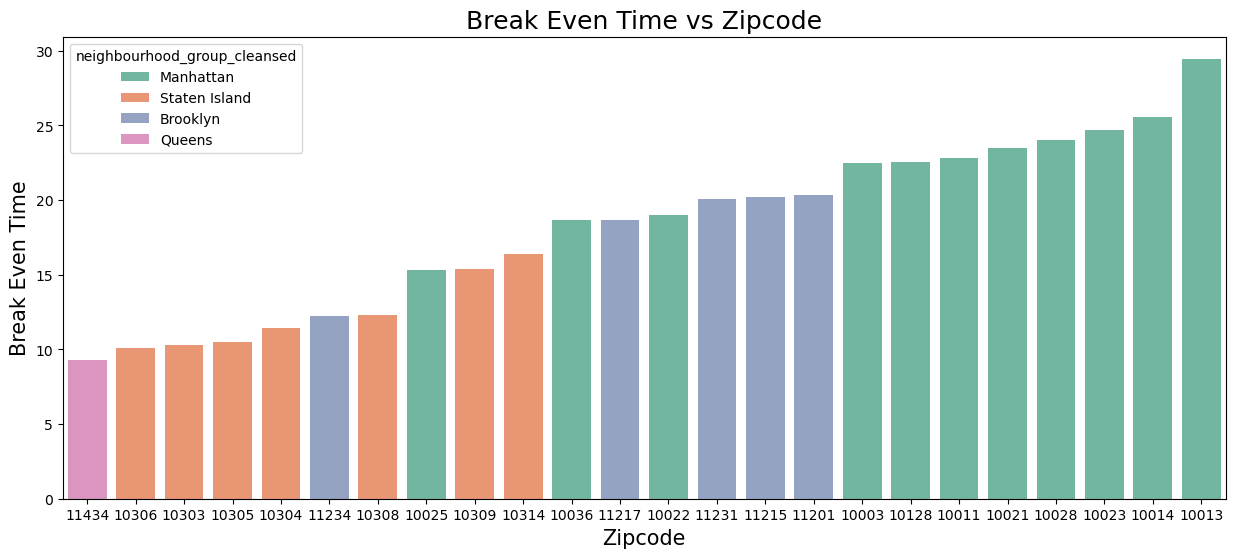

In [65]:
#Plotting the Break Even Time for each zipcode, highlighted by its location
plt.style.use("default")
plt.figure(figsize=(15,6))
sns.set_palette("Set2")
sns.barplot(x = 'RegionName',y = 'Break_Even_Time',hue = 'neighbourhood_group_cleansed',data = cost_revenue_aggregatedf, order=cost_revenue_aggregatedf.sort_values('Break_Even_Time').RegionName,dodge=False)
plt.xlabel("Zipcode", size=15)
plt.ylabel("Break Even Time", size=15)
plt.title("Break Even Time vs Zipcode", size=18)
plt.show()

#Analysis
#The plot is sorted in the increasing order of break even times. This depicts the order of zipcodes that will be 
#profitable for the company. Zipcode 11434 in Queens will be the most profitable. According to the graph, 
#zipcode 10013 in Manhattan will be the least profitable with respect to break even time, followed by zipcode 
#10014 in Manhattan.

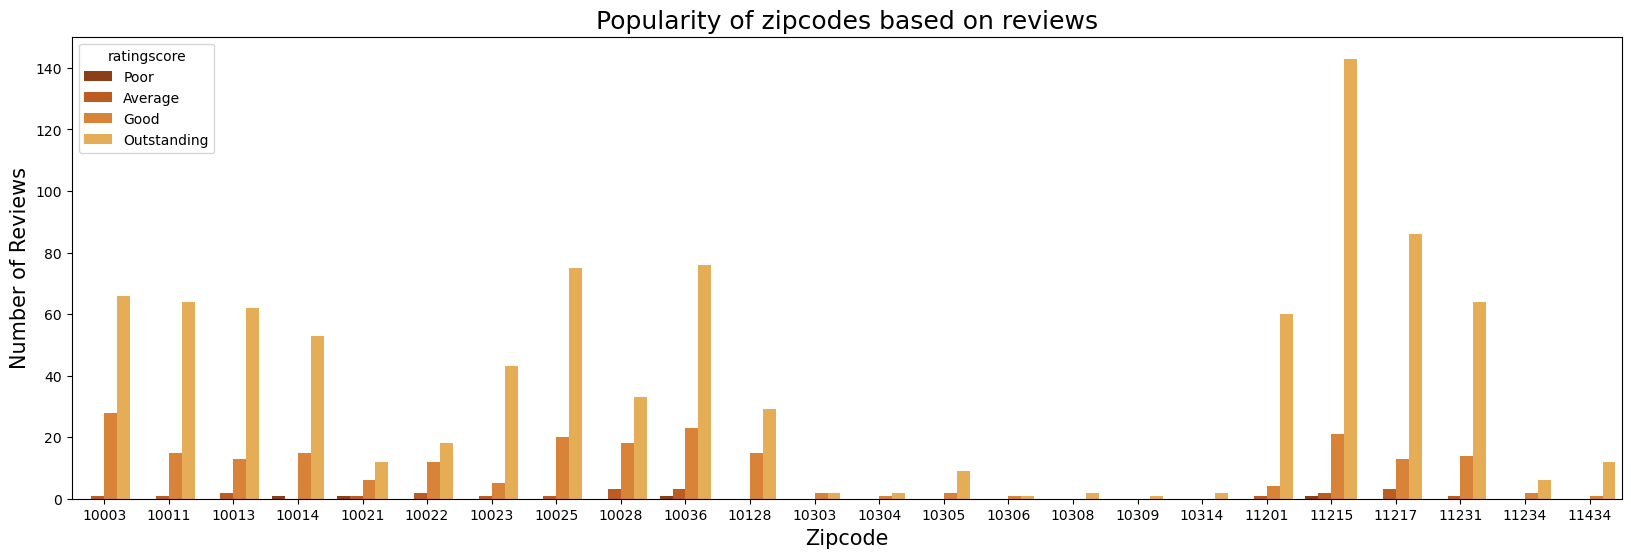

In [66]:
#Plotting the review ratings of each zipcode 
plt.style.use("default")
plt.figure(figsize=(20,6))
sns.set_palette("YlOrBr_r")
cost_revenue_mergedf['ratingscore']=pd.cut(cost_revenue_mergedf['review_scores_rating'], bins=[20,50,70,90,100], include_lowest=True, labels=['Poor', 'Average', 'Good','Outstanding'])
df = cost_revenue_mergedf.groupby(['RegionName','ratingscore'],as_index=False)['number_of_reviews'].count()
sns.barplot(x = 'RegionName',y = 'number_of_reviews',hue='ratingscore',data = df)
plt.xlabel("Zipcode", size=15)
plt.ylabel("Number of Reviews", size=15)
plt.title("Popularity of zipcodes based on reviews", size=18)
plt.show()

#Analysis
#It could be observed that the most popular zipcode is 11215 with a high count of outstanding reviews. Zipcode 11434,
#even though has the lowest break even time, has very less reviews, thus indicating that it may not be a popular 
#choice due to less bookings. Zipcodes - 10014, 10021, 10023 have high break even times and are also not popular 
#choices.

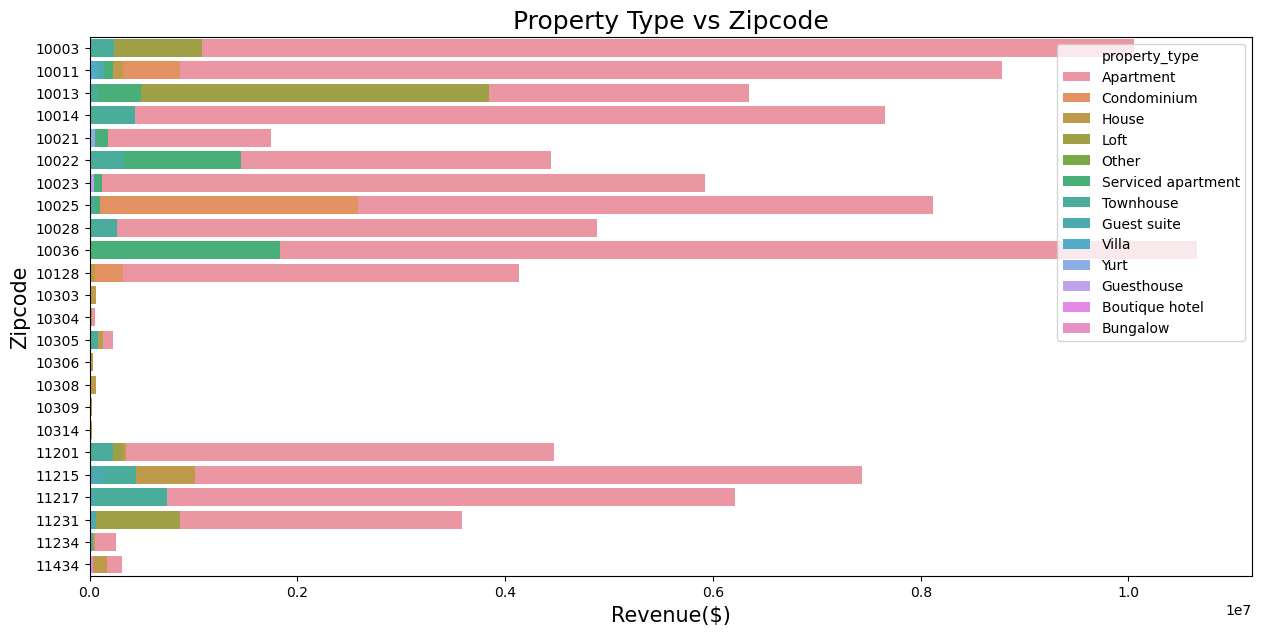

In [67]:
#Property Revenue vs Zipcode
plt.style.use("default")
plt.figure(figsize=(15,7))
sns.set_palette("mako")
df = cost_revenue_mergedf.groupby(['RegionName','property_type'],as_index=False)['yearly_revenue'].sum()
sns.barplot(x = 'yearly_revenue',y = 'RegionName',hue='property_type',data = df,orient = 'h',dodge=False)
plt.xlabel("Revenue($)", size=15)
plt.ylabel("Zipcode", size=15)
plt.title("Property Type vs Zipcode", size=18)
plt.show()

#Analysis
#It could be observed that among the various 2 bedroom properties, apartments generate highest revenue 
#across almost all zipcodes.

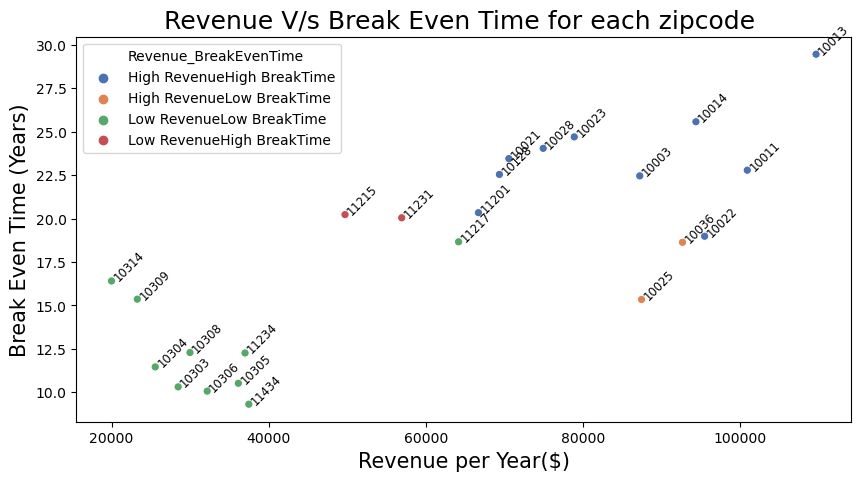

In [68]:
#Plotting Revenue V/s Break Even Time for each zipcode 
plt.style.use("default")
plt.figure(figsize=(10,5))
cost_median=cost_revenue_aggregatedf['yearly_revenue'].median()
time_median=cost_revenue_aggregatedf['Break_Even_Time'].median()
cost_revenue_aggregatedf['Revenue_Category'] = ["High Revenue" if x >= cost_median else "Low Revenue" for x in cost_revenue_aggregatedf['yearly_revenue']]
cost_revenue_aggregatedf['BreakEvenTime_Category'] = ["High BreakTime" if x >= time_median else "Low BreakTime" for x in cost_revenue_aggregatedf['Break_Even_Time']]
cost_revenue_aggregatedf['Revenue_BreakEvenTime'] = cost_revenue_aggregatedf['Revenue_Category'] + cost_revenue_aggregatedf['BreakEvenTime_Category']
p1 = sns.scatterplot(data=cost_revenue_aggregatedf, x='yearly_revenue', y='Break_Even_Time',hue = "Revenue_BreakEvenTime", palette="deep")


for line in range(0,cost_revenue_aggregatedf.shape[0]):
    p1.text(cost_revenue_aggregatedf.yearly_revenue[line],cost_revenue_aggregatedf.Break_Even_Time[line], cost_revenue_aggregatedf.RegionName[line],rotation='45', 
            size='small', color='black', weight='normal')


plt.xlabel('Revenue per Year($)',size=15)
plt.ylabel('Break Even Time (Years)',size=15)
plt.title("Revenue V/s Break Even Time for each zipcode ", size=18)
plt.show()

#Analysis
#The plot distinguishes zipcodes based on revenue and break even time. 
#Ideal zipcodes would be zipcodes with high revenue and low break even time as they would be the most profitable. 
#10025 and 10036 are high revenue-low break even time zipcodes. Most of the low revenue-low break even time 
#zipcodes such as 11434, 10309, 10304, 10303 belong to Queens and Staten Island neighbourhoods. 
#Such properties have low cost and due to the low demand and location,they have low rents resulting in low revenue. 
#Similarly, most of the high revenue-high break even time zipcodes such as 10003, 10021, 10028 all belong to Manhattan
#neighbourhood. The high cost causes the high break even time and the high revenue comes from the high rent due 
#to the demand in Manhattan.

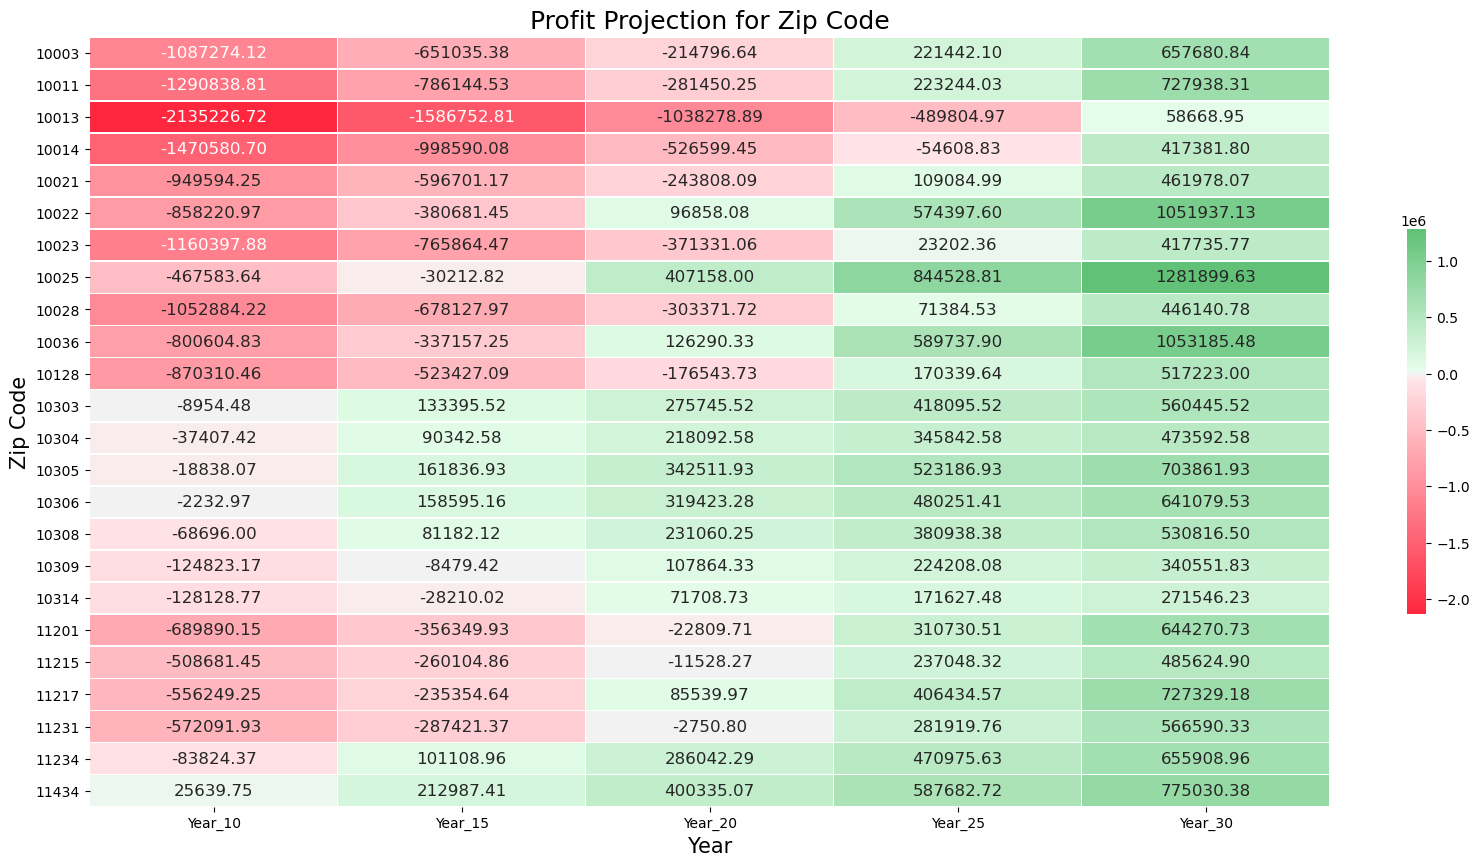

In [69]:
#Plotting Profit Projection for Zip Code
profitmap = pd.pivot_table(cost_revenue_aggregatedf,['Year_10','Year_15','Year_20','Year_25','Year_30'],'RegionName')
#profitmap.head()
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
plt.figure(figsize = (20,10))
#sns.heatmap(profitmap,cmap=cmap, annot=True,fmt=".1f")
sns.heatmap(profitmap, annot=True, fmt='.2f', cmap=rdgn, vmin=cost_revenue_aggregatedf.Year_10.min(), vmax=cost_revenue_aggregatedf.Year_30.max(),center=0.00, linewidths=.5, annot_kws={"size": 12}, cbar_kws={"shrink": .5})
plt.xlabel('Year',size=15)
plt.ylabel('Zip Code',size=15)
plt.title("Profit Projection for Zip Code", size=18)
plt.show()

#Analysis
#While Break Even time gives the zipcode with earliest profit estimates, it does not indicate the maximum 
#profitable zipcodes. The best approach is to identify the profitable zipcodes over a long term. 
#Since the minimum break even time is 9 years, the profit projections for 10,15,20,25 and 30 years is 
#as computed in the plot.
#From the plot, it could be observed that while zipcode 11434 generates profits the earliest(starting from 10 years),
#the zipcode that generates the highest profit after 20 years is 10025. In another 5 years, at year 25, 
#the most profitable zipcodes are 10025, followed by 10036 and 10022 and the same trend follows up till 30 years. 
#The lowest profit is generated in zipcodes 10013, followed by 10314 and 10309.

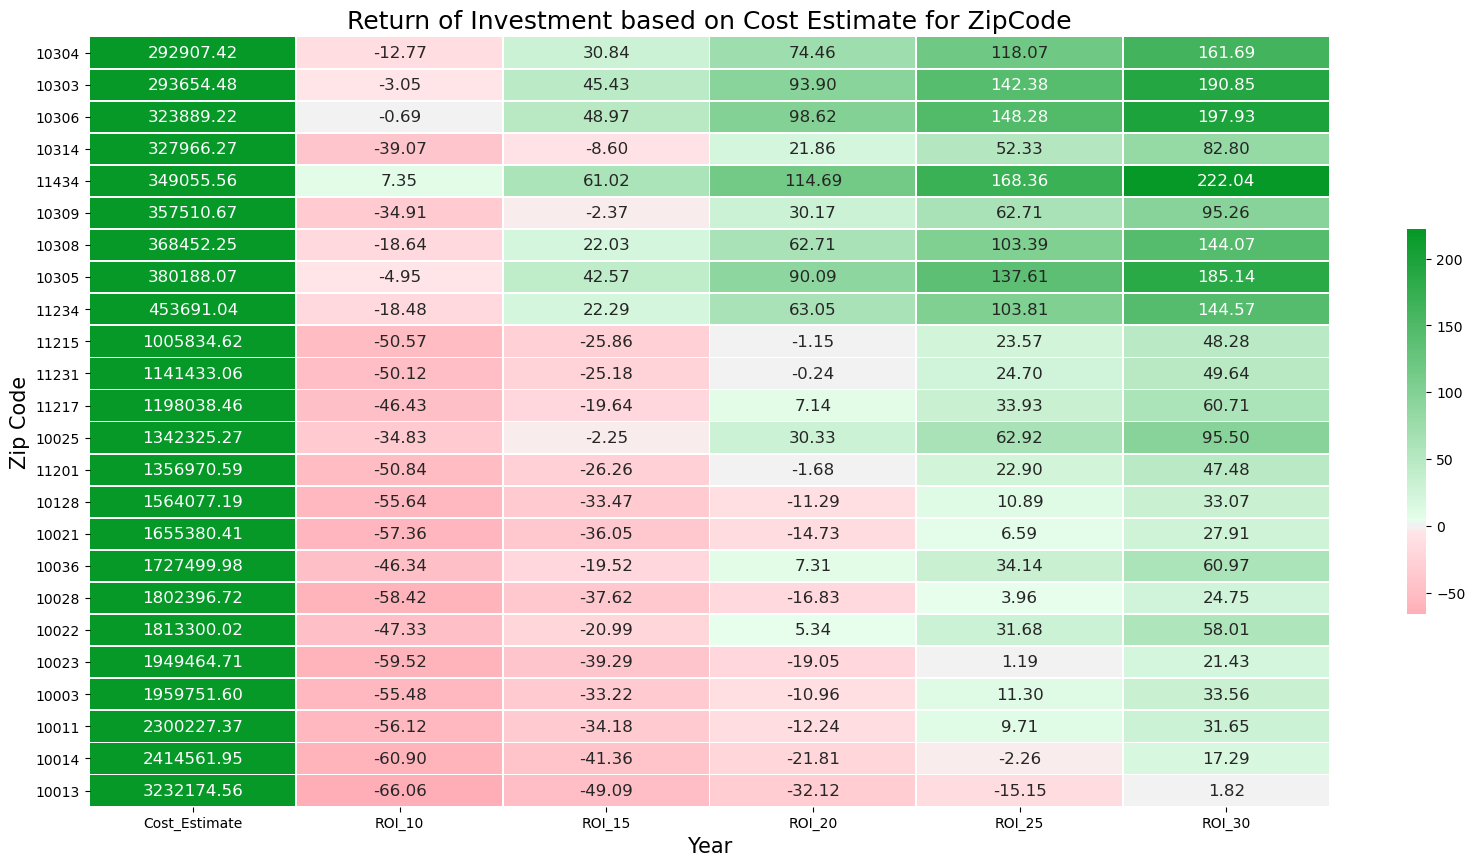

In [70]:
#Plotting ROI Projection for Zip Code
profitmap = pd.pivot_table(cost_revenue_aggregatedf,['Cost_Estimate','ROI_10','ROI_15','ROI_20','ROI_25','ROI_30'],'RegionName')
profitmap = profitmap.reindex(profitmap['Cost_Estimate'].sort_values(ascending=True).index)
rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
plt.figure(figsize = (20,10))
sns.heatmap(profitmap, annot=True, fmt='.2f', cmap=rdgn, vmin=cost_revenue_aggregatedf.ROI_10.min(), vmax=cost_revenue_aggregatedf.ROI_30.max(),center=0.00, linewidths=.5, annot_kws={"size": 12}, cbar_kws={"shrink": .5})
plt.xlabel('Year',size=15)
plt.ylabel('Zip Code',size=15)
plt.title("Return of Investment based on Cost Estimate for ZipCode", size=18)
plt.show()

#Analysis
#The zipcodes are sorted in the increasing order of cost. It could be observed that in terms of ROI, 
#the most profitable zipcodes are 11434 with an investment cost of 349K(dollars). It is the 5th least costing 
#zipcode with a very high ROI percentage(more than 200 per cent). This is followed by zipcodes 10306, 10303 and 
#10305, all of which have very high ROI percentages(more than 180 per cent). The lowest ROI are generated for 
#zipcodes 10013, 10014 and 10023. These are also zipcodes very low profit projections over a 30 year span, so 
#these zipcodes would be poor choices for investment.